In [1]:
import torch
import numpy as np
import random
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader, Subset
from collections import defaultdict
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
import cv2

In [2]:
def set_seed(seed=42):
    # Python's random module
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # For GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(42)

In [3]:
class CLAHEonV(object):
    def __call__(self, img):
        # Convert the image to RGB if it is not already in RGB format
        if img.mode != 'RGB':
            img = img.convert("RGB")
        img_np = np.array(img)

        # Convert the image to HSV using OpenCV
        hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)

        # Apply CLAHE to the V channel (value channel)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        hsv[..., 2] = clahe.apply(hsv[..., 2])  # Apply CLAHE on the V channel

        # Convert back to HSV, no need to convert to RGB as the output should be HSV
        img_hsv = Image.fromarray(hsv, 'HSV')
        
        return img_hsv

In [4]:
dataset_path = r'C:\Users\hp\OneDrive\Documents\Degree\BMCS2133 Image Processing\Drowning-Detection\cropped_data\train'

In [5]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128
    CLAHEonV(),  # Apply CLAHE on the V channel
    transforms.ToTensor()  # Convert the image to a tensor
])

In [6]:
# Load the full dataset (without actually loading images)
full_dataset = ImageFolder(dataset_path, transform=transform)
labels = full_dataset.targets  # Access labels directly (faster!)

# Desired number of samples per class
samples_per_class = 5159

# Dictionary to store indices for each class
class_indices = defaultdict(list)

# Group indices by their class label
for idx, label in enumerate(labels):
    if len(class_indices[label]) < samples_per_class:
        class_indices[label].append(idx)

# Combine indices of all classes
subset_indices = [idx for indices in class_indices.values() for idx in indices]
subset_dataset = Subset(full_dataset, subset_indices)

# Split the subset into training and validation sets
train_size = int(0.8 * len(subset_dataset))
val_size = len(subset_dataset) - train_size
train_dataset, val_dataset = random_split(subset_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check the sizes of the splits
print(f"Total subset images: {len(subset_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Total subset images: 9515
Training images: 7612
Validation images: 1903


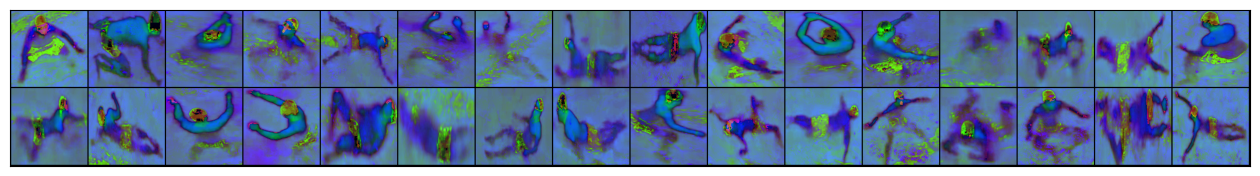

In [7]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Accuracy Calculation Function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# Evaluation Function (Validation Phase)
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# Training Loop Function
def fit(num_epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accs = []
        
        for batch in train_loader:
            loss_dict = model.training_step(batch)
            loss = loss_dict['train_loss']
            acc = loss_dict['train_acc']
            
            train_losses.append(loss)
            train_accs.append(acc)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation Phase
        result = evaluate(model, val_loader)
        
        # Record train and validation stats
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history


# Base Class for Image Classification Models
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                        # Generate predictions
        loss = F.cross_entropy(out, labels)       # Calculate loss
        acc = accuracy(out, labels)               # Calculate accuracy
        return {'train_loss': loss, 'train_acc': acc} 
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                        # Generate predictions
        loss = F.cross_entropy(out, labels)       # Calculate loss
        acc = accuracy(out, labels)               # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, train_acc: {result['train_acc']:.4f}, "
              f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


# The Model (for 128x128 images)
class SimpleCNN(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 16x16

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 8x8
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        x = self.network(xb)
        x = self.fc_layers(x)
        return x


In [9]:
num_epochs = 5
model = SimpleCNN(3)
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 0.4691, train_acc: 0.8240, val_loss: 0.2687, val_acc: 0.9031
Epoch [1], train_loss: 0.2564, train_acc: 0.9116, val_loss: 0.1975, val_acc: 0.9296
Epoch [2], train_loss: 0.2107, train_acc: 0.9303, val_loss: 0.1979, val_acc: 0.9364
Epoch [3], train_loss: 0.1684, train_acc: 0.9439, val_loss: 0.1828, val_acc: 0.9395
Epoch [4], train_loss: 0.1389, train_acc: 0.9527, val_loss: 0.1485, val_acc: 0.9489


In [10]:
# Plot Training and Validation Loss/Accuracy
def plot_metrics(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()


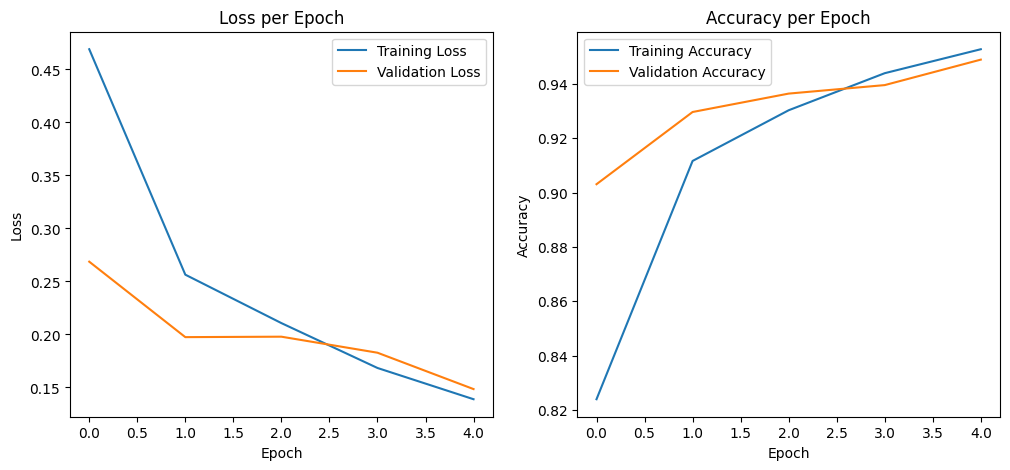

In [11]:
plot_metrics(history)

In [12]:
test_dataset_path = r'C:\Users\hp\OneDrive\Documents\Degree\BMCS2133 Image Processing\Drowning-Detection\cropped_data\val'

# Load the new dataset
test_dataset = ImageFolder(test_dataset_path, transform=transform)

# Create DataLoader for the new dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
import time

# Start timer
start_time = time.time()

test_result = evaluate(model, test_loader)

# End timer
end_time = time.time()

# Calculate time taken
time_taken = end_time - start_time

# Display results
print(f"Test Loss: {test_result['val_loss']:.4f}")
print(f"Test Accuracy: {test_result['val_acc']:.4f}")
print(f"Time Taken for Testing: {time_taken:.2f} seconds")


Test Loss: 0.0869
Test Accuracy: 0.9694
Time Taken for Testing: 18.98 seconds


In [14]:
from PIL import Image

def predict_image(image_path, model):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        RGBToHSV(),
        transforms.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, dim=1)
    
    return full_dataset.classes[predicted.item()]

In [15]:
try_path = r'C:\Users\hp\OneDrive\Documents\Degree\BMCS2133 Image Processing\Drowning-Detection\cropped_data\val\drowning\200010.jpg'

print(predict_image(try_path, model))

NameError: name 'RGBToHSV' is not defined